In [1]:
from matplotlib import pyplot
%pylab inline
import urllib.request
import re
import pandas as pd
import datetime
import time
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Read the dataframe being created by the other notebook ###

In [2]:
%cd /home/andre/PycharmProjects/geonumerics/ipython_notebooks

/home/andre/PycharmProjects/geonumerics/ipython_notebooks


In [3]:
%%time

try:
    dfdata = pd.read_pickle('real_time_quotes.pandas')
    dfdata = dfdata.set_index(pd.DatetimeIndex(dfdata['time']))
    dfdata.drop('time', axis='columns', inplace=True) #not need anymore
except:
    pass

print(len(dfdata))

4689
CPU times: user 1.35 ms, sys: 3.7 ms, total: 5.05 ms
Wall time: 4.72 ms


### RANDOM TARGET VARIABLE ###

In [4]:
#targeti = np.random.randint(0, len(dfdata.columns))
#target_quote = 'AUD/USD' # TARGET VARIABLE
#target_quote = 'EUR/AUD' # TARGET VARIABLE
#target_quote = 'EUR/USD' # TARGET VARIABLE
#target_quote = 'GBP/USD' # TARGET VARIABLE
#target_quote = 'USD/CAD' # TARGET VARIABLE
#target_quote = 'USD/NOK' # TARGET VARIABLE
target_quote = 'AUD/JPY' # TARGET VARIABLE
#target_quote = dfdata.columns[targeti]
print(target_quote)

AUD/JPY


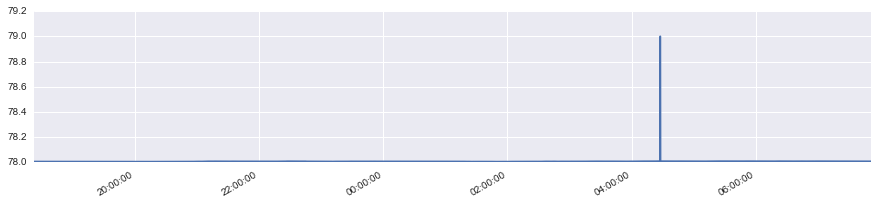

In [5]:
pyplot.figure(figsize(15,3))
dfdata[target_quote].plot()
# store this serie for use at the end
serie_target = dfdata[target_quote]

### AFTER QUICK LOOK DATA, CHOOSE THE AMOUNT OF DATA TO USE ###

In [6]:
# just last 500 samples too much data
#dt = 10. # seconds
dt = pd.Timedelta(10, unit='s')
# one hour samples
#onehour = int(60*1./dt)
# two hour samples
#twohour = int(120*1./dt)
#dfdata = dfdata.tail(onehour)

In [7]:
%cd /home/andre/PycharmProjects/geonumerics/source/python/Forex
import RF_Forex
#%reload(RF_Forex)

/home/andre/PycharmProjects/geonumerics/source/python/Forex


/home/andre/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### set the price variation to calculate zig_zag patern ###

Beware that depending on the price variation it may give 
an error bellow not being able to plot or calculate zig-zag

In [ ]:
# zzdeltas, serie_pivots = RF_Forex.create_binary_zig_zag_class(dfdata, target_quote, 0.00005, plot=True)
# create the binary classification class "du"
series_data_du = dfdata['du'] # save a copy for future use

number of samples shifted  970


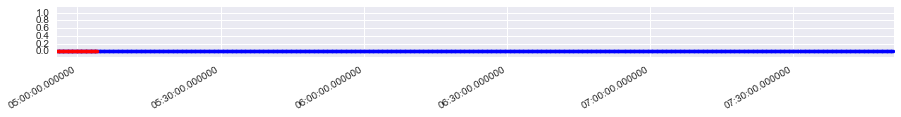

In [9]:
# shifting 2 samples, set NAN for the last two samples that are future 
# values we dont know YET. We will predict then
# since mean is of 22 minutes = 22*6 samples for prediction
#shift = 2
shift = round(zzdeltas[0].total_seconds()/dt.total_seconds()) # zzdeltas[0] mean delta time
print('number of samples shifted ', shift)
series_data_dup = RF_Forex.make_shift_binary_class(dfdata, shift) 

In [10]:
# time of the last valid sample for traininig
# and last sample recorded
time_index_training = series_data_dup.dropna(inplace=False).index  
last_time_real = series_data_dup.index[-1] 
last_time_training = series_data_dup.dropna(inplace=False).index[-1] 

In [11]:
# remove the target_quote/target_variable and create many indicators
# can improve here with new indicators, RSI discrete
RF_Forex.create_indicators(dfdata, target_quote);

In [18]:
# normalize 0 to 1
dfdata = dfdata.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
dfdata.head(1)

,EUR/USD,AUD/USD,EUR/GBP,USD/CHF,USD/CAD,EUR/CHF,EUR/AUD,USD/NOK,GBP/JPY,ema_5 EUR/USD,...,EUR/USD+AUD/USD,AUD/USD+GBP/USD,GBP/USD+EUR/GBP,EUR/GBP+USD/CHF,USD/CHF+USD/CAD,EUR/CHF+EUR/AUD,EUR/AUD+USD/NOK,USD/NOK+GBP/JPY,target_variable_dup,UpDown
3,0.704698,0.207399,0.651709,0.385542,0.712662,0.536913,0.829917,0.443923,0.006012,0.727041,...,0.267803,0.250163,0.527574,0.462203,0.605027,0.815385,0.576365,0.011535,1.0,1.0


In [13]:
RF_Forex.calculate_corr_and_remove(dfdata, series_data_dup)
# 5 first and 5 last correlations

ema_10 USD/CHF    0.385016
ema_5 USD/CHF     0.384985
ema_15 USD/CHF    0.384905
USD/CHF           0.384107
ema_15 EUR/CHF    0.295225
Name: target_variable_dup, dtype: float64
ema_5 GBP/USD     0.003077
dema_5 GBP/JPY    0.002944
ema_10 GBP/USD    0.002591
ema_15 GBP/USD    0.001964
rsi_20 GBP/JPY    0.001960
Name: target_variable_dup, dtype: float64


In [14]:
# remove time index to make it possible through sckit-learn
dfdata.reset_index(inplace=True, drop=True)
series_data_dup.reset_index(inplace=True, drop=True)
dfdata['target_variable_dup'] = pd.Series(series_data_dup, index=dfdata.index)
dfdata.head(1)

,EUR/USD,AUD/USD,EUR/GBP,USD/CHF,USD/CAD,EUR/CHF,EUR/AUD,USD/NOK,GBP/JPY,ema_5 EUR/USD,...,ema_15 GBP/JPY,EUR/USD+AUD/USD,AUD/USD+GBP/USD,GBP/USD+EUR/GBP,EUR/GBP+USD/CHF,USD/CHF+USD/CAD,EUR/CHF+EUR/AUD,EUR/AUD+USD/NOK,USD/NOK+GBP/JPY,target_variable_dup
0,0.14963,-0.223857,-0.007029,-0.165189,0.187551,-0.041482,0.294898,-0.07911,-0.305315,0.154606,...,-0.305157,-0.135596,-0.074324,0.136305,-0.156291,0.04363,0.293703,0.024366,-0.301586,1.0


 ### Separate variables for PREDICTION and TRAINING ###

In [15]:
df2predict = dfdata[ pd.isnull(dfdata['target_variable_dup']) ] 
dfdata.dropna(inplace=True)
df2predict.drop('target_variable_dup', axis='columns', inplace=True)

/home/andre/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [16]:
# should use everything all samples otherwise I choose a different 
# number of samples in the begining 
print(len(dfdata))
X_train, y_train = RF_Forex.prepareDataForClassification(dfdata) # index of sample to split

3715


### QUICK ANALYSIS OF ALL DATA ###

In [17]:
#%timeit
accuracies, clfmodel = RF_Forex.performCV_analysis(X_train, y_train, 60, nvalidate=shift)

Size train set:  (3715, 63)
samples in each window:  60
number of analysis:  46


KeyboardInterrupt: 

In [ ]:
accuracies_index = np.array([time_index_training[i] for i in accuracies[0]])
pdaccuracies = pd.DataFrame(accuracies[1], columns=['accuracy'],
                        index=accuracies_index)

In [ ]:
print(np.mean(accuracies[1]))
print(target_quote)
fig, axr = pyplot.subplots(1, sharex=True, figsize=(15,4))
# average 8
pdaccuracies['mean'] = pdaccuracies.accuracy.ewm(span=8).mean()
pdaccuracies['perc45'] = pd.Series(np.ones(len(accuracies[1]))*0.6897, index=pdaccuracies.index) # 45%
pdaccuracies['perc70'] = pd.Series(np.ones(len(accuracies[1]))*0.5882, index=pdaccuracies.index) # 70%
pdaccuracies['perc80'] = pd.Series(np.ones(len(accuracies[1]))*0.5556, index=pdaccuracies.index) # 80%
pdaccuracies.plot(ax=axr, ylim=(-0.5, 1.5))

### Create special window do validate training and see if it will go up  or down ###

1. Use the last samples to visually see if it is still predicting correctly
2. Plot over or among the original price chart the predictions

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

def see_prediction(serie_target, average_delta, serie_pivots, serie_du,
                   clfmodel, data2predict, shift, dt):
    # plot the last samples corresponding to 5 mean zig zag values
    nsee=7
    fig, axr = plt.subplots(2, sharex=True, figsize=(15,4))
    serie_target[ serie_target.index > (serie_target.index[-1] - zzdeltas[0]*nsee) ].plot(ax=axr[0])
    selection = serie_pivots[ serie_pivots.index > (serie_pivots.index[-1] - zzdeltas[0]*nsee) ]
    serie_target[selection.index].plot(ax=axr[0], style='ok--')
    serie_du[serie_du.index > (serie_du.index[-1] - zzdeltas[0]*nsee)].plot(ax=axr[1], style='k--')
    # prediction        
    # original position of the predictor sample
    serie_prediction_orig = pd.Series(np.ones(data2predict.index.size)*0.5, 
                                      index=serie_target.index[data2predict.index]) 
    serie_prediction_orig.plot(ax=axr[1], style='.g')
    
    # those are predictions need to have the corresponding shift in time
    fst_predict_time = serie_target.index[data2predict.index[0]]+dt*shift
    serie_prediction = pd.Series(clfmodel.predict(data2predict), 
                                 index=pd.date_range(fst_predict_time, 
                                                     periods=data2predict.index.size, freq=dt))
    serie_prediction.plot(ax=axr[1], style='.g-')
    #print(serie_prediction.values)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)
    #ax.axvline(pd.to_datetime('2015-11-01'), color='r', linestyle='--', lw=2)

In [ ]:
see_prediction(serie_target, zzdeltas[0], serie_pivots, series_data_du,
               clfmodel, df2predict, shift, dt)
#print(last_time_training)
print(last_time_real)

In [ ]:
deltas = pd.Series([serie_pivots.index[i+1]-serie_pivots.index[i] for i in range(serie_pivots.index.size-1)])

In [ ]:
deltas = deltas.apply(lambda x : x.total_seconds()/60.)

In [ ]:
deltas.hist(bins=80)

In [ ]:
t = plt.hist(np.log(deltas), bins=40);